In [1]:
import multiprocessing
import tqdm

import numpy as np
import scipy.stats as st
import numba

#import biocircuits

# Plotting modules
import bokeh.io
import bokeh.plotting

import math
import matplotlib.pyplot as plt

bokeh.io.output_notebook()

# Line profiler (can install with conda install line_profiler)
#%load_ext line_profiler

Loading BokehJS ...

In [2]:
# Column 0 is change in m, column 1 is change in p
simple_update = np.array([[-1, 1],   # State A to B
                          [1, -1]    # State B to A
                                 ], # Degrade protein
                         dtype=int)

In [3]:
def simple_propensity(propensities, population, t, k1, k2):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    A, B = population
    
    # Update propensities
    propensities[0] = k1*A          # State A to B 
    propensities[1] = k2*B           # State B to A

In [4]:
def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

In [5]:
def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

In [6]:
def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

In [52]:
# Specify parameters for calculation
args = (10.0, 100.0)
time_points = np.linspace(0, 50, 101)
population_0 = np.array([0, 100], dtype=int)
size = 200

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 2), dtype=int)

# Run the calculations
for i in tqdm.tqdm_notebook(range(size)):
    samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                population_0, time_points, args=args)

C:\Users\denni\AppData\Local\Temp\ipykernel_9568\3407189243.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(size)):


  0%|          | 0/200 [00:00<?, ?it/s]

In [53]:
# Set up plots
plots = [bokeh.plotting.figure(plot_width=300,
                               plot_height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='A'),
         bokeh.plotting.figure(plot_width=300,
                               plot_height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='B')]

# Plot trajectories and mean
for i in [0, 1]:
    for x in samples[:,:,i]:
        plots[i].line(time_points, x, line_width=0.3, 
                      alpha=0.2, line_join='bevel')
    plots[i].line(time_points, samples[:,:,i].mean(axis=0),
                  line_width=6, color='orange', line_join='bevel')

# Link axes
plots[0].x_range = plots[1].x_range

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=2))

Using the equation derived for the probability of x molecules inside the droplet;

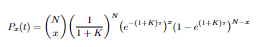

In [54]:
N = 100
t = np.arange(0, 101, 1)

Solving for the equation as time tends to infinity;

In [55]:
K = args[1]/args[0]
series = []
for x in range(0, t.shape[0]):
    series.append((math.comb(N, x)*K**x)/(1+K)**N)

Calculating the expected value of the distribution or the first moment, we get;

In [57]:
expected_value(t, series)

90.9090909090909

(Which is the mean of the number of molecules inside the droplet according to the Gillespie algorithm)

Calculating the average variance (second moment) of the last 10 snapshots of the Gillespie algorithm solution;

In [67]:
np.array([np.var(np.array(samples[:, i, 0])) for i in range(-10, 0)]).mean()

8.542925

Calculating the variance (second moment) of the analytically obtained distribution;

E(X^2) - [E(X)]^2

In [68]:
expected_value(t**2, series) - (expected_value(t, series))**2

8.264462809918768